In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gzip
import warnings
import seaborn as sns

In [2]:
# One-hot encoding of the labels
def one_hot_encoding(label_data):
    unique_labels = np.unique(label_data)
    encoded_labels = np.zeros((label_data.shape[0], unique_labels.shape[0]))
    for i in range(label_data.shape[0]):
        encoded_labels[i][label_data[i]] = 1
    return encoded_labels

# Function to read pixel data from the dataset
def read_pixels(data_path):
    with gzip.open(data_path) as f:
        pixel_data = np.frombuffer(f.read(), 'B', offset=16).astype('float32')
    normalized_pixels = pixel_data / 255
    flattened_pixels = normalized_pixels.reshape(normalized_pixels.shape[0] // 784,784) 
    return flattened_pixels

# Function to read label data from the dataset
def read_labels(data_path):
    with gzip.open(data_path) as f:
        label_data = np.frombuffer(f.read(), 'B', offset=8)
    one_hot_encoding_labels = one_hot_encoding(label_data)
    return one_hot_encoding_labels

# Function to read the entire dataset
def read_dataset():
    X_train = read_pixels("data/train-images-idx3-ubyte.gz")
    y_train = read_labels("data/train-labels-idx1-ubyte.gz")
    X_test = read_pixels("data/t10k-images-idx3-ubyte.gz")
    y_test = read_labels("data/t10k-labels-idx1-ubyte.gz")
    return X_train, y_train, X_test, y_test

In [3]:
X_train, y_train, X_test, y_test = read_dataset()

In [4]:
# setting the random seed
np.random.seed(42)

In [5]:
def train_valid_split(X_train, y_train, no_valid):
    '''
    Function to split the training data into training and validation sets

    Parameters:
        X_train: training data
        y_train: training labels 
        no_valid: number of validation samples

    Returns:
        X_train: training data
        y_train: training labels
        X_valid: validation data
        y_valid: validation labels
    '''
    # shuffling the indices
    shuffled_indices = np.random.permutation(X_train.shape[0])
    # shuffling the data
    X_train_shuffled = X_train[shuffled_indices]
    y_train_shuffled = y_train[shuffled_indices]
    # splitting the data
    X_valid, X_train = X_train_shuffled[:no_valid], X_train_shuffled[no_valid:]
    y_valid, y_train = y_train_shuffled[:no_valid], y_train_shuffled[no_valid:]

    # returning the data
    return X_train, y_train, X_valid, y_valid

In [6]:
# splitting the X_train and y_train into training and validation sets
X_train, y_train, X_valid, y_valid = train_valid_split(X_train, y_train, 10000)

In [7]:
''' 
Checking the shape of the data
Expected output:

X_train shape:  (50000, 784)
y_train shape:  (50000, 10)
X_valid shape:  (10000, 784)
y_valid shape:  (10000, 10)
X_test shape:  (10000, 784)
y_test shape:  (10000, 10)
'''
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_valid shape: ", X_valid.shape)
print("y_valid shape: ", y_valid.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)


X_train shape:  (50000, 784)
y_train shape:  (50000, 10)
X_valid shape:  (10000, 784)
y_valid shape:  (10000, 10)
X_test shape:  (10000, 784)
y_test shape:  (10000, 10)


In [8]:
class MLR:
    def __init__(self):
        '''
        Constructor method
        '''
        self.weights = None
        self.bias = None
        self.train_acc = []
        self.valid_acc = []
        self.isTrained = False

    def __softmax(self, z):
        '''
        Private method to compute softmax of the input

        Parameters:
            z: input

        Returns:
            softmax of the input
        '''
        # computing the softmax
        # to avoid overflow, subtracting the max value from the input if necessary
        with warnings.catch_warnings():
            try:
                # computing the softmax
                return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)
            except RuntimeWarning:
                # subtracting the max value from the input
                z = z - np.max(z, axis=1, keepdims=True)
                # computing the softmax
                return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)
            
    def __calculate_accuracy(self, y_true, y_pred):
        '''
        Private method to compute the accuracy of the model

        Parameters:
            y_true: true labels
            y_pred: predicted labels

        Returns:
            accuracy of the model
        '''
        # computing the accuracy
        return np.sum(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1)) / y_true.shape[0]
    
    def __reset_weights_and_bias(self, no_features, no_classes, weight_initialazation):
        '''
        Private method to reset (or to initialize) the weights and bias

        Parameters:
            no_features: number of features
            no_classes: number of classes

        Returns:
            None
        '''
        # resetting the weights and bias
        if weight_initialazation == "normal":
            self.weights = np.random.normal(size=(no_features, no_classes))
            self.bias = np.random.normal(size=(1, no_classes))

        elif weight_initialazation == "zeros":
            self.weights = np.zeros(shape=(no_features, no_classes))
            self.bias = np.zeros(shape=(1, no_classes))

        elif weight_initialazation == "uniform":
            self.weights = np.random.uniform(size=(no_features, no_classes))
            self.bias = np.random.uniform(size=(1, no_classes))

        else:
            print("Invalid weight initialization method!")
            return None

        # resetting the training and validation accuracy
        self.train_acc = []
        self.valid_acc = []

    def __forward_propagation(self, X):
        '''
        Private method to compute the forward propagation

        Parameters:
            X: input

        Returns:
            softmax of the input
        '''
        # computing the forward propagation
        z = X @ self.weights + self.bias
        z = self.__softmax(z)
        return z
    
    def __backward_propagation(self, X, y_true, y_pred):
        '''
        Private method to compute the backward propagation

        Parameters:
            X: input
            y_true: true labels
            y_pred: predicted labels

        Returns:
            gradients of the weights and bias
        '''
        # computing the gradients

        # derivative of the cross entropy loss with respect to z (before softmax)
        dz = y_pred - y_true

        # derivative of the cross entropy loss with respect to weights
        dw = X.T @ dz

        # derivative of the cross entropy loss with respect to bias
        db = np.sum(dz, axis=0, keepdims=True)

        # returning the gradients
        return dw, db
    
    def __update_weights_and_bias(self, dw, db, learning_rate, lambda_):
        '''
        Private method to update the weights and bias

        Parameters:
            dw: gradients of the weights
            db: gradients of the bias
            learning_rate: learning rate
            lambda_: regularization parameter

        Returns:
            None
        '''
        # updating the weights and bias
        self.weights -= learning_rate * (dw + lambda_ * self.weights)
        self.bias -= learning_rate * db

    def train(self, X_train = None, y_train = None, valid_data = None, lr = None, lambda_ = None, batch_size = None, epochs = 100, verbose = 0, weight_initialazation = "normal"):
        '''
        Public method to train the model

        Parameters:
            X_train: training data
            y_train: training labels
            valid_data: validation data
            lr: learning rate
            lambda_: regularization parameter
            batch_size: batch size
            epochs: number of epochs
            verbose: verbosity

        Returns:
            None
        '''
        # resetting the weights and bias
        self.__reset_weights_and_bias(X_train.shape[1], y_train.shape[1], weight_initialazation)

        # starting the training
        for epoch in range(1, epochs+1):
            # slicing the data into batches
            for i in range(0, X_train.shape[0], batch_size):
                # getting the batch
                X_batch = X_train[i:i+batch_size] 
                y_batch = y_train[i:i+batch_size]

                # computing the forward propagation
                y_pred = self.__forward_propagation(X_batch)

                # computing the backward propagation
                dw, db = self.__backward_propagation(X_batch, y_batch, y_pred)

                # updating the weights and bias
                self.__update_weights_and_bias(dw, db, lr, lambda_)

            # computing the training accuracy
            train_acc = self.__calculate_accuracy(y_train, self.__forward_propagation(X_train))
            # adding the training accuracy to the list
            self.train_acc.append(train_acc)

            # check if validation data is provided
            if valid_data:
                # computing the validation accuracy
                valid_acc = self.__calculate_accuracy(valid_data[1], self.__forward_propagation(valid_data[0]))
                # adding the validation accuracy to the list
                self.valid_acc.append(valid_acc)

            # printing the training and validation accuracy if exist and verbose is 1 one by one and if 2 every 10 epochs in a single line
            if verbose == 1:
                epoch_message = "Epoch: " + str(epoch) + " - Training Accuracy: " + str(self.train_acc[-1])
                if valid_data:
                    epoch_message += " - Validation Accuracy: " + str(self.valid_acc[-1])
                print(epoch_message)
            elif verbose == 2 and epoch % 10 == 0:
                epoch_message = "Epoch: " + str(epoch) + " - Training Accuracy: " + str(self.train_acc[-1])
                if valid_data:
                    epoch_message += " - Validation Accuracy: " + str(self.valid_acc[-1])
                print(epoch_message)
                

        # setting the isTrained flag to True
        self.isTrained = True

    def classify(self, X):
        '''
        Public method to classify the labels

        Parameters:
            X: input

        Returns:
            predicted labels
        '''
        # check if the model is trained
        if not self.isTrained:
            print("Model is not trained yet!")
            return None
        
        # check if the input size is correct
        if X.shape[1] != self.weights.shape[0]:
            print("Input size is not correct!")
            return None

        # computing the forward propagation
        y_pred = self.__forward_propagation(X)

        # returning the predicted labels
        return y_pred
    
    def plot_valid_accuracy(self, title):
        '''
        Public method to plot the validation accuracy

        Parameters:
            None

        Returns:
            None
        '''
        # check if the model is trained
        if not self.isTrained:
            print("Model is not trained yet!")
            return None

        # plotting the validation accuracy
        plt.plot(self.valid_acc)
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title(title)
        plt.show()

    
    def get_valid_acc(self):
        '''
        Public method to get the validation accuracy

        Parameters:
            None

        Returns:
            valid_acc: validation accuracy
        '''
        # check if the model is trained
        if not self.isTrained:
            print("Model is not trained yet!")
            return None

        # returning the validation accuracy
        return self.valid_acc

In [9]:
mlr = MLR()

In [10]:
DEFAULT_LR = 5e-4
DEFAULT_LAMBDA = 1e-4
DEFAULT_BATCH_SIZE = 200
DEFAULT_WEIGHT_INITIALIZATION = "normal"

In [11]:
mlr.train(
    X_train = X_train,
    y_train = y_train,
    valid_data = (X_valid, y_valid),
    lr = DEFAULT_LR,
    lambda_ = DEFAULT_LAMBDA,
    batch_size = DEFAULT_BATCH_SIZE,
    weight_initialazation = DEFAULT_WEIGHT_INITIALIZATION,
    verbose = 2,
)

Epoch: 10 - Training Accuracy: 0.85006 - Validation Accuracy: 0.8434
Epoch: 20 - Training Accuracy: 0.87412 - Validation Accuracy: 0.8698
Epoch: 30 - Training Accuracy: 0.88662 - Validation Accuracy: 0.8803
Epoch: 40 - Training Accuracy: 0.89336 - Validation Accuracy: 0.8863
Epoch: 50 - Training Accuracy: 0.89832 - Validation Accuracy: 0.8903
Epoch: 60 - Training Accuracy: 0.90186 - Validation Accuracy: 0.8934
Epoch: 70 - Training Accuracy: 0.90438 - Validation Accuracy: 0.8962
Epoch: 80 - Training Accuracy: 0.90706 - Validation Accuracy: 0.8975
Epoch: 90 - Training Accuracy: 0.90956 - Validation Accuracy: 0.8992
Epoch: 100 - Training Accuracy: 0.91122 - Validation Accuracy: 0.9014


In [12]:
# calculating the test accuracy
def calculate_accuracy(y_true, y_pred):
    '''
    Function to compute the accuracy of the model

    Parameters:
        y_true: true labels
        y_pred: predicted labels

    Returns:
        accuracy of the model
    '''
    # computing the accuracy
    return np.sum(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1)) / y_true.shape[0]

In [42]:
def confusion_matrix(y_true, y_pred):
    ''' 
    Function to compute the confusion matrix

    Parameters:
        y_true: true labels
        y_pred: predicted labels

    Returns:
        confusion matrix
    '''
    # getting the classes
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # getting the number of classes
    num_classes = y_true.shape[1]

    # initializing the confusion matrix
    conf_matrix = np.zeros((num_classes, num_classes))

    # filling the confusion matrix
    for i in range(len(y_true_classes)):
        conf_matrix[y_true_classes[i]][y_pred_classes[i]] += 1

    # returning the confusion matrix
    return conf_matrix

In [14]:
def visualize_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    '''
    Visualizes the confusion matrix.

    Parameters:
        y_true: array, shape (n_samples,), true labels
        y_pred: array, shape (n_samples,), predicted labels
        class_labels: array, labels of each class
    '''

    # calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    _, ax = plt.subplots(figsize=(10,10))
    # plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = "Reds", ax=ax)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

Test Accuracy:  0.9062


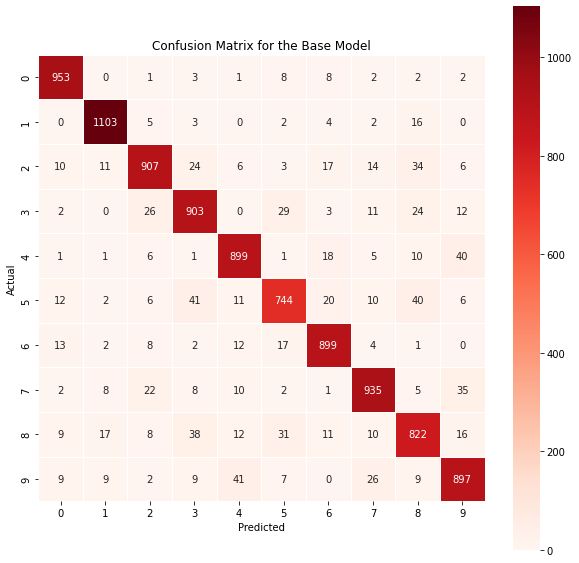

In [15]:
# calculating the test accuracy and plotting the confusion matrix
y_pred = mlr.classify(X_test)
test_acc = calculate_accuracy(y_test, y_pred)
print("Test Accuracy: ", test_acc)
visualize_confusion_matrix(y_test, y_pred, title="Confusion Matrix for the Base Model")

In [16]:
# hyperparameter dictionary
hyperparameters = {
    "BATCH_SIZE": [1, 64, 50000],
    "WEIGHT_INITIALIZATION": ["zeros", "uniform", "normal"],
    "LEARNING_RATE": [0.1, 1e-3, 1e-4, 1e-5],
    "LAMBDA": [1e-2, 1e-4, 1e-9],
}

In [17]:
# best hyperparameters dictionary, to be updated
best_hyperparameters = {
    "BATCH_SIZE": None,
    "WEIGHT_INITIALIZATION": None,
    "LEARNING_RATE": None,
    "LAMBDA": None,
}

In [18]:
# hyperparameter accuracies dictionary, to be updated
hyperparameter_accuracies = {
    "BATCH_SIZE": [0,0,0],
    "WEIGHT_INITIALIZATION": [0,0,0],
    "LEARNING_RATE": [0,0,0,0],
    "LAMBDA": [0,0,0],
}

In [19]:
def plot_accuracies(hyperparameters, accuracies, title):
    # accuracies is a list of lists
    # each list corresponds to a hyperparameter value
    # each list contains the accuracies for each epoch
    # plotting the accuracies
    for i in range(len(accuracies)):
        plt.plot(accuracies[i], label=hyperparameters[title][i])
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.title("Validation Accuracy vs Epochs for Different " + title)
    plt.legend()
    plt.show()


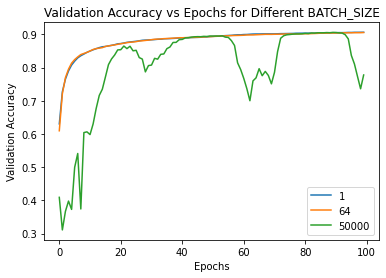

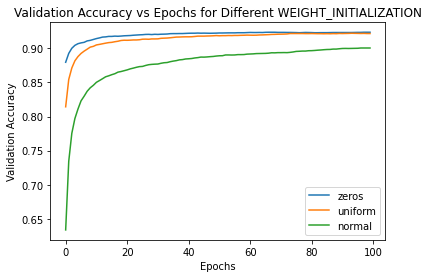

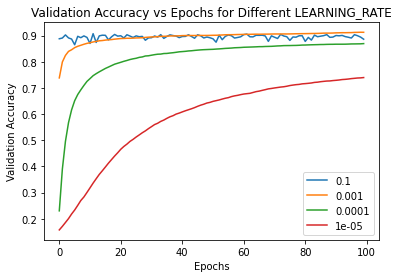

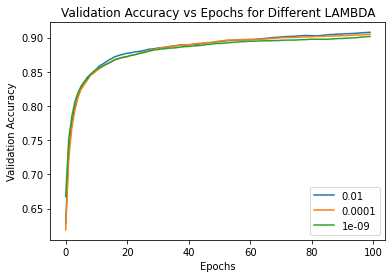

In [20]:
# training the model with different hyperparameters and saving the accuracies

for hyperparameter in hyperparameters:
    # iterating over the hyperparameter values
    valid_accs = []
    for value in hyperparameters[hyperparameter]:
        # setting the hyperparameter value
        if hyperparameter == "BATCH_SIZE":
            learning_rate = DEFAULT_LR
            batch_size = value
            lambda_ = DEFAULT_LAMBDA
            weight_initialazation = DEFAULT_WEIGHT_INITIALIZATION
        elif hyperparameter == "WEIGHT_INITIALIZATION":
            learning_rate = DEFAULT_LR
            batch_size = DEFAULT_BATCH_SIZE
            lambda_ = DEFAULT_LAMBDA
            weight_initialazation = value
        elif hyperparameter == "LEARNING_RATE":
            learning_rate = value
            batch_size = DEFAULT_BATCH_SIZE
            lambda_ = DEFAULT_LAMBDA
            weight_initialazation = DEFAULT_WEIGHT_INITIALIZATION
        elif hyperparameter == "LAMBDA":
            learning_rate = DEFAULT_LR
            batch_size = DEFAULT_BATCH_SIZE
            lambda_ = value
            weight_initialazation = DEFAULT_WEIGHT_INITIALIZATION

        epochs = 100

        # training the model
        mlr.train(
            X_train = X_train,
            y_train = y_train,
            valid_data = (X_valid, y_valid),
            lr = learning_rate,
            lambda_ = lambda_,
            batch_size = batch_size,
            weight_initialazation = weight_initialazation,
            epochs = epochs,
            verbose=0,
        )

        # calculating the validation accuracy
        valid_acc = mlr.get_valid_acc()
        # adding the validation accuracy to the list

        # store the validation accuracy (sorry for the hardcoding :D)
        hyperparameter_accuracies[hyperparameter][hyperparameters[hyperparameter].index(value)] = valid_acc

        
    # plotting the accuracies
    plot_accuracies(hyperparameters, hyperparameter_accuracies[hyperparameter], hyperparameter)

    # getting the best hyperparameter value (sorry again for the hardcoding :D)
    best_hyperparameters[hyperparameter] = hyperparameters[hyperparameter][np.argmax(np.array(hyperparameter_accuracies[hyperparameter])[:, -1])]
        

In [21]:
best_hyperparameters

{'BATCH_SIZE': 1,
 'WEIGHT_INITIALIZATION': 'zeros',
 'LEARNING_RATE': 0.001,
 'LAMBDA': 0.01}

In [22]:
np.array(hyperparameter_accuracies["BATCH_SIZE"])[:, -1]

# since there is 0.09 difference between the accuracies of batch size 1 and 64, I will choose 64 as the batch size 
# to reduce the training time

best_hyperparameters["BATCH_SIZE"] = 64

In [23]:
# training the model with the best hyperparameters, calculating the test accuracy and plotting the confusion matrix

# setting the best hyperparameters
mlr.train(
    X_train = X_train,
    y_train = y_train,
    valid_data = (X_valid, y_valid),
    lr = best_hyperparameters["LEARNING_RATE"],
    lambda_ = best_hyperparameters["LAMBDA"],
    batch_size = best_hyperparameters["BATCH_SIZE"],
    weight_initialazation = best_hyperparameters["WEIGHT_INITIALIZATION"],
    epochs = 100,
    verbose=1,
)

Epoch: 1 - Training Accuracy: 0.89312 - Validation Accuracy: 0.8923
Epoch: 2 - Training Accuracy: 0.90336 - Validation Accuracy: 0.904
Epoch: 3 - Training Accuracy: 0.90896 - Validation Accuracy: 0.9073
Epoch: 4 - Training Accuracy: 0.91288 - Validation Accuracy: 0.9102
Epoch: 5 - Training Accuracy: 0.91526 - Validation Accuracy: 0.9126
Epoch: 6 - Training Accuracy: 0.91696 - Validation Accuracy: 0.9148
Epoch: 7 - Training Accuracy: 0.91824 - Validation Accuracy: 0.9167
Epoch: 8 - Training Accuracy: 0.91922 - Validation Accuracy: 0.9171
Epoch: 9 - Training Accuracy: 0.92016 - Validation Accuracy: 0.9179
Epoch: 10 - Training Accuracy: 0.9206 - Validation Accuracy: 0.918
Epoch: 11 - Training Accuracy: 0.92122 - Validation Accuracy: 0.9182
Epoch: 12 - Training Accuracy: 0.92188 - Validation Accuracy: 0.919
Epoch: 13 - Training Accuracy: 0.92242 - Validation Accuracy: 0.9195
Epoch: 14 - Training Accuracy: 0.92296 - Validation Accuracy: 0.9201
Epoch: 15 - Training Accuracy: 0.92344 - Valida

Test Accuracy:  0.9259


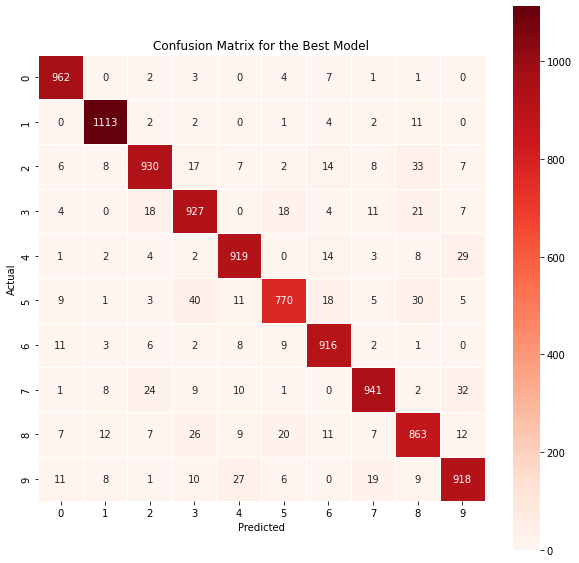

In [24]:
# calculating the test accuracy and plotting the confusion matrix
y_pred = mlr.classify(X_test)
test_acc = calculate_accuracy(y_test, y_pred)
print("Test Accuracy: ", test_acc)
visualize_confusion_matrix(y_test, y_pred, title="Confusion Matrix for the Best Model")

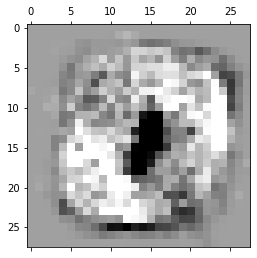

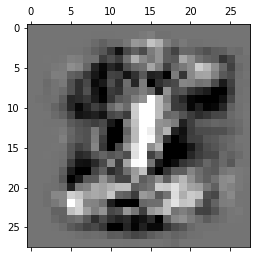

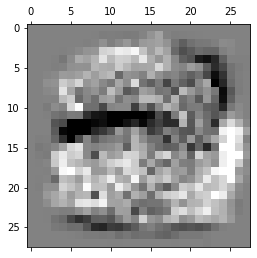

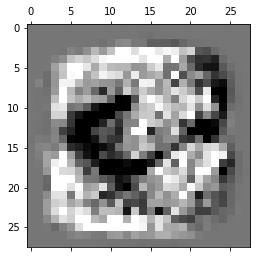

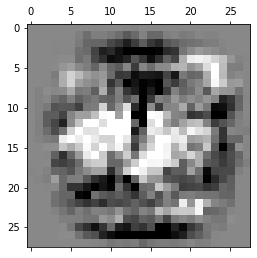

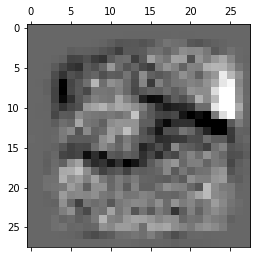

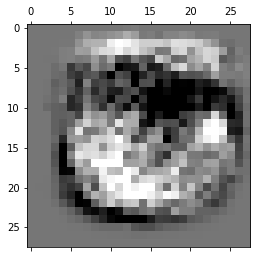

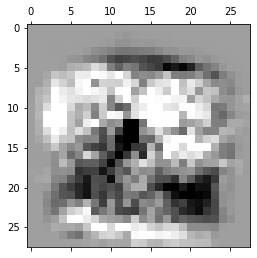

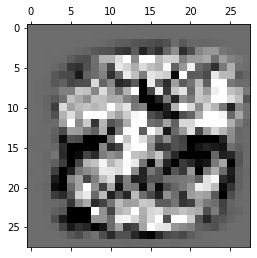

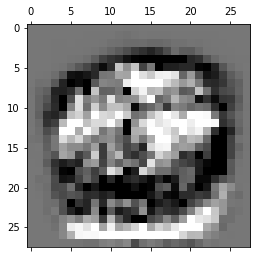

In [36]:
# taking 10 weights from best model
weights = mlr.weights.T
weights = weights.reshape(10, 28, 28)

# plotting the weights
for i, weight in enumerate(weights):
    plt.matshow(weight, cmap=plt.cm.gray, vmin=0.5*weight.min(), vmax=0.5*weight.max())

In [37]:
# function to calculate the precision given the confusion matrix
def calculate_precision(conf_matrix):
    '''
    Function to calculate the precision given the confusion matrix

    Parameters:
        conf_matrix: confusion matrix

    Returns:
        precision
    '''
    # calculating the precision
    return np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)

# function to calculate the recall given the confusion matrix
def calculate_recall(conf_matrix):
    '''
    Function to calculate the recall given the confusion matrix

    Parameters:
        conf_matrix: confusion matrix

    Returns:
        recall
    '''
    # calculating the recall
    return np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

# function to calculate the f score given the precision and recall, beta is 1 by default
def calculate_f_score(precision, recall, beta=1):
    '''
    Function to calculate the f score given the precision and recall, beta is 1 by default

    Parameters:
        precision: precision
        recall: recall
        beta: beta

    Returns:
        f score
    '''
    # calculating the f score
    return (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

In [46]:
# calculating the precision, recall and f score
conf_matrix = confusion_matrix(y_test, y_pred)

precision = calculate_precision(conf_matrix)
recall = calculate_recall(conf_matrix)
f1_score = calculate_f_score(precision, recall, beta=1)
f2_score = calculate_f_score(precision, recall, beta=2)

In [48]:
# printing the precision, recall and f scores for each number
for i in range(10):
    print("Precision for number " + str(i) + ": ", precision[i])
    print("Recall for number " + str(i) + ": ", recall[i])
    print("F1 Score for number " + str(i) + ": ", f1_score[i])
    print("F2 Score for number " + str(i) + ": ", f2_score[i])
    print("-"*50)

Precision for number 0:  0.950592885375494
Recall for number 0:  0.9816326530612245
F1 Score for number 0:  0.965863453815261
F2 Score for number 0:  0.9752635847526357
--------------------------------------------------
Precision for number 1:  0.9636363636363636
Recall for number 1:  0.9806167400881057
F1 Score for number 1:  0.9720524017467249
F2 Score for number 1:  0.9771729587357332
--------------------------------------------------
Precision for number 2:  0.9327983951855566
Recall for number 2:  0.9011627906976745
F1 Score for number 2:  0.916707737801873
F2 Score for number 2:  0.9073170731707318
--------------------------------------------------
Precision for number 3:  0.8930635838150289
Recall for number 3:  0.9178217821782179
F1 Score for number 3:  0.9052734375000001
F2 Score for number 3:  0.9127609294998031
--------------------------------------------------
Precision for number 4:  0.9273461150353178
Recall for number 4:  0.9358452138492872
F1 Score for number 4:  0.9315